# **GENDER PREDICTION IN TWITTER**

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Sun Nov 25 14:25:15 2018

@author: vkach
"""
import pandas as pd
import numpy
import re
import string
import ast
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.model_selection import KFold
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, RFE, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from dateutil import parser
from pandas import DataFrame , read_csv
import matplotlib
import matplotlib.pyplot as plt
import datetime
import os
import seaborn as sns

/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


> **FILE READ**

In [56]:
'''File read'''
data_set = pd.read_csv("../input/gender-classifier-DFE-791531.csv", encoding = "latin-1" )
test_file_ds = None #pd.read_csv("../input/gender-classifier-DFE-791531.csv", encoding = "latin-1" ) # Please give in the same format as above line
is_test = False
lemma = nltk.WordNetLemmatizer()  

# Data Preprocessing

In [57]:
'''Data Preprocessing'''
#Gender confidence level taken as 1
cleaned_data_set = data_set[data_set["gender:confidence"] == 1]

#Remove gender unknown
df1 = cleaned_data_set["gender"] != "unknown"
cleaned_data_set = cleaned_data_set[df1]

#Dropping columns
cleaned_data_set = cleaned_data_set.drop(columns = ["_unit_id", "_golden", "_unit_state", "_trusted_judgments", 
                                                    "gender_gold", "profile_yn_gold", "tweet_id"])

#Drops duplicate account
cleaned_data_set = cleaned_data_set.drop_duplicates("name")

In [58]:
cleaned_test_file_ds = None
if(is_test == True):
    '''Data Preprocessing'''
    #Gender confidence level taken as 1
    cleaned_test_file_ds = test_file_ds[test_file_ds["gender:confidence"] == 1]

    #Remove gender unknown
    df1 = cleaned_test_file_ds["gender"] != "unknown"
    cleaned_test_file_ds = cleaned_test_file_ds[df1]

    #Dropping columns
    cleaned_test_file_ds = cleaned_test_file_ds.drop(columns = ["_unit_id", "_golden", "_unit_state", "_trusted_judgments", 
                                                        "gender_gold", "profile_yn_gold", "tweet_id"])

    #Drops duplicate account
    cleaned_test_file_ds = cleaned_test_file_ds.drop_duplicates("name")

> Class created for tweet preprocessing

In [59]:
class TweetCleaner:
    #1 - punctautaion
    def __init__(self, tweets, key):
        self.stop_words = set(stopwords.words('english'))
        self.punc_table = str.maketrans("", "", string.punctuation) # to remove punctuation from each word in tokenize
        self.keys = key
        self.test_features = self.clean_tweets(tweets)
    def remove_non_ascii_chars(self, text):
        return ''.join([w if ord(w) < 128 and not w.isdigit() else ' ' for w in text])
    def remove_hyperlinks(self,text):
        return ' '.join([w for w in text.split(' ')  if not 'http' in w])
    def get_cleaned_text(self, text):
        cleaned_text = text.replace('\"','').replace('\'','').replace('-',' ')
        cleaned_text =  self.remove_non_ascii_chars(cleaned_text)
        if re.match(r'RT @[_A-Za-z]+:',cleaned_text):
            cleaned_text = cleaned_text[cleaned_text.index(':')+2:]
        if(3 in self.keys):
            cleaned_text = re.sub(r'@[_A-Za-z]+', "", cleaned_text)
        cleaned_text = self.remove_hyperlinks(cleaned_text)
        cleaned_text = cleaned_text.replace('#','HASHTAGSYMBOL').replace(r'@[_A-Za-z]+:',' ') # to avoid being removed while removing punctuations
        tokens = None
        if(1 in self.keys):
            tokens = [w.translate(self.punc_table) for w in word_tokenize(cleaned_text)] # remove punctuations and tokenize
        else:
            tokens = [w for w in word_tokenize(cleaned_text)] # remove punctuations and tokenize
        #No stemming - decreases accuracy
        if(2 in self.keys):
            tokens = [lemma.lemmatize(w) for w in tokens if not w.lower() in self.stop_words and len(w)>1] # remove stopwords and single length words
        else:
            tokens = [lemma.lemmatize(w) for w in tokens if len(w)>1] # remove stopwords and single length words
        cleaned_text = ' '.join(tokens)
        cleaned_text = cleaned_text.replace('HASHTAGSYMBOL','#').replace('ATSYMBOL','@')
        cleaned_text = cleaned_text
        return cleaned_text
    def clean_tweets(self, tweets):   
        test_tweet_list = []
        for tweet in tweets:
            test_tweet_list.append(self.get_cleaned_text(tweet))
        return test_tweet_list

> Bar plot - Count of colors for each gender

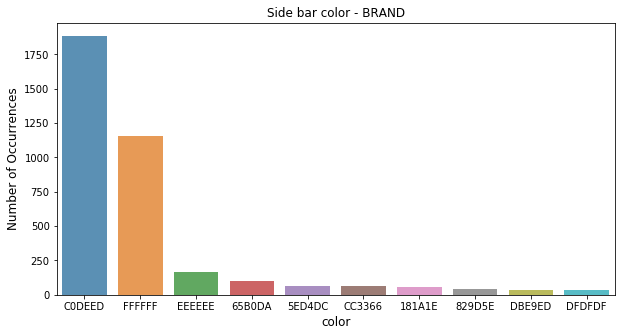

In [60]:
df1 = cleaned_data_set["gender"] == "female" # This should be changed for each gender
df2 = cleaned_data_set["sidebar_color"] != "0"
city_count = cleaned_data_set[df1 & df2]
city_count  = city_count['sidebar_color'].value_counts()
city_count = city_count[:10,]
plt.figure(figsize=(10,5))
sns.barplot(city_count.index, city_count.values, alpha=0.8)
plt.title('Side bar color - BRAND')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('color', fontsize=12)
plt.show()

> Gender count

In [61]:
cleaned_data_set["gender"].value_counts()

female    5159
male      4518
brand     3444
Name: gender, dtype: int64

> **Color section**

In [62]:
#Function to convert color hex codes to RGB
def hexa_to_rgb(color, default):
    if color == '0':
        color =  default
        r=int(color[0:2],16)
        g=int(color[2:4],16)
        b=int(color[4:6],16)
        return r,g,b
    if len(color)<5:
        color = default
        r=int(color[0:2],16)
        g=int(color[2:4],16)
        b=int(color[4:6],16)
        return r,g,b
    try:
        r=int(color[0:2],16)
        g=int(color[2:4],16)
        b=int(color[4:6],16)
    except (RuntimeError, TypeError, NameError, ValueError):
        color = default
        r=int(color[0:2],16)
        g=int(color[2:4],16)
        b=int(color[4:6],16)
        return r,g,b
    else:
        return r,g,b

In [63]:
if(is_test):
    cleaned_test_file_ds["r_link"] = cleaned_test_file_ds["link_color"].apply(lambda x: hexa_to_rgb(str(x), "0084B4")[0])
    cleaned_test_file_ds["g_link"] = cleaned_test_file_ds["link_color"].apply(lambda x: hexa_to_rgb(str(x), "0084B4")[1])
    cleaned_test_file_ds["b_link"] = cleaned_test_file_ds["link_color"].apply(lambda x: hexa_to_rgb(str(x), "0084B4")[2])
    cleaned_test_file_ds["rs_side"] = cleaned_test_file_ds["sidebar_color"].apply(lambda x: hexa_to_rgb(str(x), "C0DEED")[0])
    cleaned_test_file_ds["gs_side"] = cleaned_test_file_ds["sidebar_color"].apply(lambda x: hexa_to_rgb(str(x), "C0DEED")[1])
    cleaned_test_file_ds["bs_side"] = cleaned_test_file_ds["sidebar_color"].apply(lambda x: hexa_to_rgb(str(x), "C0DEED")[2])

In [64]:
cleaned_data_set["r_link"] = cleaned_data_set["link_color"].apply(lambda x: hexa_to_rgb(str(x), "0084B4")[0])
cleaned_data_set["g_link"] = cleaned_data_set["link_color"].apply(lambda x: hexa_to_rgb(str(x), "0084B4")[1])
cleaned_data_set["b_link"] = cleaned_data_set["link_color"].apply(lambda x: hexa_to_rgb(str(x), "0084B4")[2])
cleaned_data_set["rs_side"] = cleaned_data_set["sidebar_color"].apply(lambda x: hexa_to_rgb(str(x), "C0DEED")[0])
cleaned_data_set["gs_side"] = cleaned_data_set["sidebar_color"].apply(lambda x: hexa_to_rgb(str(x), "C0DEED")[1])
cleaned_data_set["bs_side"] = cleaned_data_set["sidebar_color"].apply(lambda x: hexa_to_rgb(str(x), "C0DEED")[2])

In [65]:
X_train, X_test, y_train, y_test =  train_test_split(cleaned_data_set[['r_link','g_link','b_link','rs_side','gs_side','bs_side']], 
                 cleaned_data_set['gender'], test_size= 0.20, random_state = 2)

> Cross Validation for DecisionTree, RandomForest, Linear SVC  ["

In [66]:
le = preprocessing.LabelEncoder()
le.fit(cleaned_data_set['gender'])
gender_encoder = le.transform(cleaned_data_set['gender']) 

In [67]:
best_accuracy = None
best_estimator = None

In [68]:
if(not is_test):
    decision_tree_classifier = DecisionTreeClassifier()
    parameter_grid = {'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9],
                      'max_features': [1, 2, 3, 4, 5],
                      'random_state': [2]
                      }
    grid_search = GridSearchCV(decision_tree_classifier, param_grid = parameter_grid, cv = 5)
    grid_search.fit(cleaned_data_set[['r_link','g_link','b_link','rs_side','gs_side','bs_side']], cleaned_data_set['gender'])
    print("Best Decision Tree Classifier Score: {}".format(grid_search.best_score_))
    print("Best Decision Tree Classifier params: {}".format(grid_search.best_params_))

Best Decision Tree Classifier Score: 0.4413535553692554
Best Decision Tree Classifier params: {'max_depth': 7, 'max_features': 4, 'random_state': 2}


In [69]:
random_tree_classifier = RandomForestClassifier()
parameter_grid = {'n_estimators': list(range(1,20)),
                  'random_state': [2],
                  'max_depth' : [1,2,3,4,5,6,7,8,9]}
grid_search = GridSearchCV(random_tree_classifier, param_grid = parameter_grid, cv = 5)
grid_search.fit(cleaned_data_set[['r_link','g_link','b_link','rs_side','gs_side','bs_side']], gender_encoder)
print("Best Random Forest Classifier Score: {}".format(grid_search.best_score_))
print("Best Random Forest Classifier params: {}".format(grid_search.best_params_))
best_accuracy = grid_search.best_score_
best_estimator= grid_search.best_estimator_

Best Random Forest Classifier Score: 0.446764728298148
Best Random Forest Classifier params: {'max_depth': 8, 'n_estimators': 19, 'random_state': 2}


In [70]:
if(not is_test):
    knn_neighbors = KNeighborsClassifier()
    parameter_grid = {'n_neighbors': list(range(1,40))}
    grid_search = GridSearchCV(knn_neighbors, param_grid = parameter_grid, cv = 5)
    grid_search.fit(cleaned_data_set[['r_link','g_link','b_link','rs_side','gs_side','bs_side']], gender_encoder)
    print("Best KNN Score: {}".format(grid_search.best_score_))
    print("Best KNN params: {}".format(grid_search.best_params_))

Best KNN Score: 0.4313695602469324
Best KNN params: {'n_neighbors': 33}


In [71]:
if(not is_test):
    gb_neighbors = GaussianNB()
    parameter_grid = {}
    grid_search = GridSearchCV(gb_neighbors, param_grid = parameter_grid, cv = 5)
    grid_search.fit(cleaned_data_set[['r_link','g_link','b_link','rs_side','gs_side','bs_side']], gender_encoder)
    print("Best Gaussian NB Score: {}".format(grid_search.best_score_))
    print("Best Gaussian NB params: {}".format(grid_search.best_params_))

Best Gaussian NB Score: 0.3833549272159134
Best Gaussian NB params: {}


In [72]:
def train_model(classifier, feature_vector_train, label, feature_vector_valid,valid_y):
    classifier.fit(feature_vector_train, label)
    predictions = classifier.predict(feature_vector_valid)
    return accuracy_score(predictions, valid_y), classifier.predict_proba(feature_vector_valid), precision_score(valid_y, classifier.predict(feature_vector_valid),average=None), classifier

In [73]:
color_accuracy, color_predictions, color_prec, color_classifier = train_model(best_estimator, X_train, y_train, X_test, y_test)
print(color_accuracy)

0.44571428571428573


In [74]:
def getPrediction(Probabs):
    return [ numpy.argmax(x) for x in Probabs]

In [75]:
def data_set_splitter(gender):
    cleaned_data_set_1 = cleaned_data_set
    if(gender):
        cleaned_data_set_1 = cleaned_data_set[cleaned_data_set["gender"] == gender]
    return cleaned_data_set_1

def cleaned_description(data_set, keys):
    desc_list = [str(desc) for desc in data_set["description"]]
    cleaned_desc = TweetCleaner(desc_list, keys).test_features
    return cleaned_desc

def cleaned_tweet3(data_set, keys):
    cleaned_tweet = TweetCleaner(data_set["name"], keys).test_features
    return cleaned_tweet

def cleaned_tweet2(data_set, keys):
    cleaned_tweet = TweetCleaner(data_set["text"], keys).test_features
    return cleaned_tweet

def cleaned_tweet(data_set, keys):
    desc_list = [str(desc) for desc in data_set["description"]]
    tweets = [str(desc) for desc in data_set["text"]]
    #desc_t = TweetCleaner(desc_list).test_features
    cleaned_tweet_with_user = []
    for i in range(len(desc_list)):
            cleaned_tweet_with_user.append(tweets[i] + " " + desc_list[i])
    cleaned_tweet = TweetCleaner(cleaned_tweet_with_user, keys).test_features
    return cleaned_tweet

In [76]:
def user_name_range(text_val):
    text_val_range = []
    for rang in range(3,5):
        text_val_range.append(" ".join(["".join([str(j) for j in i]) for i in list(nltk.ngrams(text_val, rang))]))
    return " ".join(text_val_range)
cleaned_tweet_with_user = []
#for i in range(len(cleaned_data_set)):
#    cleaned_tweet_with_user.append(cleaned_tweet_with_user[i] + " " + user_name_range(cleaned_data_set["name"][cleaned_data_set["name"].index[i]]))

In [77]:
#est = RandomForestClassifier(n_estimators = 18, random_state = 42)
Y_test = None
def classfier_runner(c_name, train_features, output):
    X_train, X_test, y_train, y_test = train_test_split(train_features, output, test_size = 0.20,  random_state=2)
    global Y_test
    Y_test = y_test
    return train_model(c_name, X_train, y_train, X_test,y_test)

In [78]:
func1 = cleaned_tweet #for punctuation
func1_keys = [1]

func2_keys = [1,2,3]

func3 = cleaned_tweet3
func3_keys = [0]

In [79]:
cleaned_data_set1  = data_set_splitter(None)
cleaned_tweet_with_user_n = cleaned_tweet(cleaned_data_set1, func1_keys)
cleaned_desc_n = cleaned_description(cleaned_data_set1, func2_keys)
cleaned_username_n = cleaned_data_set1["name"]

In [80]:
def train_model2(classifier, feature_vector_valid,valid_y):
    predictions = classifier.predict(feature_vector_valid)
    return accuracy_score(predictions, valid_y), classifier.predict_proba(feature_vector_valid), precision_score(valid_y, classifier.predict(feature_vector_valid),average=None), classifier

In [81]:

cleaned_data_set1  = data_set_splitter(None)
test = list(cleaned_data_set1.columns)
test.remove("gender")
X_train, X_test, y_train, y_test =  train_test_split(cleaned_data_set1[test], 
                 cleaned_data_set['gender'], test_size= 0.20, random_state = 2)

cleaned_data_set1  = X_train
cleaned_tweet_with_user_n = func1(cleaned_data_set1, func1_keys)
cleaned_desc_n = cleaned_description(cleaned_data_set1, func2_keys)
cleaned_username_n = func3(cleaned_data_set1, func3_keys)

count_word_tweet_n = CountVectorizer(analyzer = "word", ngram_range = (1,1))
train_features_tweet_n = count_word_tweet_n.fit_transform(cleaned_tweet_with_user_n)

count_word_desc_n = CountVectorizer(analyzer = "word", ngram_range = (1,3))
train_features_desc_n = count_word_desc_n.fit_transform(cleaned_desc_n)

count_word_username_n = CountVectorizer(analyzer = "char_wb", ngram_range = (3,5))
train_features_user_n = count_word_username_n.fit_transform(cleaned_username_n)

classifier1 = MultinomialNB(alpha =1.015)
classifier2 = MultinomialNB(alpha =1.015)
classifier3 = MultinomialNB(alpha =1.015)
classifier1.fit(train_features_tweet_n, y_train)
classifier2.fit(train_features_desc_n, y_train)
classifier3.fit(train_features_user_n, y_train)


cleaned_data_set1  = X_test
cleaned_tweet_with_user_n = func1(cleaned_data_set1, func1_keys)
cleaned_desc_n = cleaned_description(cleaned_data_set1, func2_keys)
cleaned_username_n = func3(cleaned_data_set1, func3_keys)

train_features_tweet_n_test = count_word_tweet_n.transform(cleaned_tweet_with_user_n)
train_features_desc_n_test = count_word_desc_n.transform(cleaned_desc_n)
train_features_user_n_test = count_word_username_n.transform(cleaned_username_n)


In [82]:

tweet_accuracy, tweet_predictions, tweet_prec, tweet_classifier = train_model2(classifier1, train_features_tweet_n_test, y_test)
user_accuracy, user_predictions, user_prec, user_classifier = train_model2(classifier3, train_features_user_n_test, y_test)

In [83]:
print(tweet_accuracy)
print(user_accuracy)

0.6582857142857143
0.6491428571428571


In [84]:
total_Predictions = (tweet_prec*tweet_predictions + 
                     user_prec*user_accuracy)
y_pred_class = getPrediction(total_Predictions)

le = preprocessing.LabelEncoder()
le.fit(y_test)
test = le.transform(y_test) 

print("Mean accuracy: " , accuracy_score(test, y_pred_class))

Mean accuracy:  0.659047619047619


In [85]:
func1 = cleaned_tweet #for punctuation
func1_keys = [1]

func2_keys = [1,2,3]

func3 = cleaned_tweet3
func3_keys = [0]

cleaned_data_set1  = data_set_splitter(None)
cleaned_tweet_with_user_n = func1(cleaned_data_set1, func1_keys)
cleaned_desc_n = cleaned_description(cleaned_data_set1, func2_keys)
cleaned_username_n = func3(cleaned_data_set1, func3_keys)

In [86]:
def feature_selection_BOW(classifier, function_invoke, train_data, user = False, func_keys = func1_keys, vectorizer = CountVectorizer, chi = None):
    est = classifier #MultinomialNB()
    analyzer = "word"
    n_gram_range = (1, 2)
    if user:
        analyzer = "char_wb"
        n_gram_range = (3, 5)
    cleaned_data_set1_m  = data_set_splitter("male")
    cleaned_tweet_with_user_m = None
    if not user:
        cleaned_tweet_with_user_m = function_invoke(cleaned_data_set1_m, func_keys)
    else:
        cleaned_tweet_with_user_m = cleaned_data_set1_m ["name"]
    cleaned_data_set1_f  = data_set_splitter("female")
    if not user:
        cleaned_tweet_with_user_f = function_invoke(cleaned_data_set1_f, func_keys)
    else:
        cleaned_tweet_with_user_f = cleaned_data_set1_f ["name"]
    cleaned_data_set1_b  = data_set_splitter("brand")
    if not user:
        cleaned_tweet_with_user_b = function_invoke(cleaned_data_set1_b, func_keys)
    else:
        cleaned_tweet_with_user_b = cleaned_data_set1_b ["name"]
    range_accur = []
    accuracy =[]
    for i in range(1000, 60000, 5000):
        count_word_tweet_m = vectorizer(analyzer = analyzer, ngram_range = n_gram_range,min_df =2, max_features = i)
        train_features_tweet_m = count_word_tweet_m.fit_transform(cleaned_tweet_with_user_m)
        male_top_words = count_word_tweet_m.get_feature_names()

        count_word_tweet_f = vectorizer(analyzer = analyzer, ngram_range = n_gram_range, min_df =2, max_features = i)
        train_features_tweet_f = count_word_tweet_f.fit_transform(cleaned_tweet_with_user_f)
        female_top_words = count_word_tweet_f.get_feature_names()
        
        count_word_tweet_b = vectorizer(analyzer = analyzer, ngram_range = n_gram_range, min_df =2, max_features = i)
        train_features_tweet_b = count_word_tweet_b.fit_transform(cleaned_tweet_with_user_b)
        brand_top_words = count_word_tweet_b.get_feature_names()

        count_word_tweet_n = vectorizer(analyzer = analyzer, ngram_range = n_gram_range,min_df =2, vocabulary = set(male_top_words + female_top_words + brand_top_words))
        train_features_tweet_n = count_word_tweet_n.fit_transform(train_data)

        text_accuracy = cross_val_score(est, train_features_tweet_n, cleaned_data_set1["gender"], cv = 5)
        range_accur.append(i)
        accuracy.append(text_accuracy.mean())
    return range_accur, accuracy

In [87]:
x_value_t, y_value_t = feature_selection_BOW(MultinomialNB(alpha = 0.001), func1, cleaned_tweet_with_user_n)
#x_value_d, y_value_d = feature_selection_BOW(MultinomialNB(), cleaned_description, cleaned_desc_n, False, func2_keys)
x_value_u, y_value_u = feature_selection_BOW(MultinomialNB(alpha = 0.001), func1, cleaned_username_n, True)

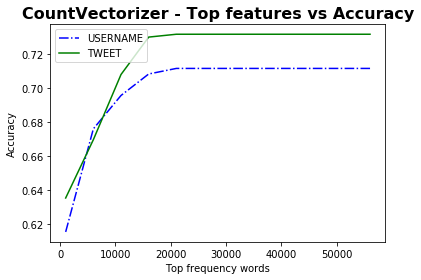

In [88]:
plt.plot(x_value_u, y_value_u, '-.', color="blue", label="USERNAME")
#plt.plot(x_value_d, y_value_d, '--', color="red", label="DESCRIPTION")
plt.plot(x_value_t, y_value_t, '-', color="green", label="TWEET")
plt.legend(loc="upper left")

plt.title("CountVectorizer - Top features vs Accuracy", fontsize = 16, fontweight='bold')
plt.xlabel("Top frequency words")
plt.ylabel("Accuracy")

plt.show()

In [89]:
print("Username: " + str(x_value_u[numpy.argmax(y_value_u)])  +" "
+ "Tweet: " + str(x_value_t[numpy.argmax(y_value_t)]))

Username: 21000 Tweet: 21000


In [90]:
func1 = cleaned_tweet #for punctuation
func1_keys = [1]

func2_keys = [1,2,3]

func3 = cleaned_tweet3
func3_keys = [0]

cleaned_data_set1  = data_set_splitter(None)
test = list(cleaned_data_set1.columns)
test.remove("gender")
X_train= None
X_test = None 
y_train= None 
y_test = None
if(is_test == False):
    X_train, X_test, y_train, y_test =  train_test_split(cleaned_data_set1[test], 
                 cleaned_data_set['gender'], test_size= 0.20, random_state = 2)
else:
    X_train = cleaned_data_set1[test]
    y_train = cleaned_data_set['gender']
    X_test = cleaned_test_file_ds[test]
    y_test  = cleaned_test_file_ds['gender']

In [91]:
def feature_selection_BOW_chi(classifier, function_invoke, output, train_data, user = False, keys = func1_keys, vectorizer = CountVectorizer, faetureCnt = 0):
    est = classifier #MultinomialNB()
    analyzer = "word"
    n_gram_range = (1, 1)
    if user:
        analyzer = "char_wb"
        n_gram_range = (3, 5)
    range_accur = []
    accuracy =[]
    feature_names = []
    estimator = []
    
    
    X_train, X_test, y_train, y_test =  train_test_split(train_data, 
                 output, test_size= 0.20, random_state = 2)
    
    count_word_tweet_n = vectorizer(analyzer = analyzer, ngram_range = n_gram_range,min_df =2)
    train_features_tweet_n = count_word_tweet_n.fit_transform(X_train)
    test2 = len(count_word_tweet_n.get_feature_names())
    if(faetureCnt != 0):
        test2 = faetureCnt

    for i in range(100, test2, 1000):
        test2 = SelectKBest(score_func=chi2, k = i)
        fit2 = test2.fit(train_features_tweet_n, y_train)
        features = fit2.transform(train_features_tweet_n)
        
        cols = test2.get_support(indices=True)
        feature = numpy.array(count_word_tweet_n.get_feature_names())[cols]
        feature_names.append(cols)
        
        count_word_tweet_q = vectorizer(analyzer = analyzer, ngram_range = n_gram_range, vocabulary = feature)
        train_features_tweet_q = count_word_tweet_q.fit_transform(X_test)
        
        est.fit(features, y_train)
        testq  = est.predict(train_features_tweet_q)
        accuracy_score(testq, y_test)
        range_accur.append(i)
        accuracy.append(accuracy_score(testq, y_test))
        estimator.append(est)
    
    best_estimator = estimator[numpy.argmax(range_accur)]
    return range_accur, accuracy, feature_names[numpy.argmax(range_accur)], best_estimator, count_word_tweet_n

In [92]:
def train_model2(classifier, feature_vector_valid,valid_y):
    predictions = classifier.predict(feature_vector_valid)
    return accuracy_score(predictions, valid_y), classifier.predict_proba(feature_vector_valid), precision_score(valid_y, classifier.predict(feature_vector_valid),average=None), classifier

In [93]:
cleaned_data_set1  = X_train
cleaned_tweet_with_user_n = cleaned_tweet(cleaned_data_set1, func1_keys)

In [94]:

x_value_t, y_value_t,feature_names_t, train_features_t, trans_t  = feature_selection_BOW_chi(MultinomialNB(alpha = 1.015), func1, y_train, cleaned_tweet_with_user_n, False, func1_keys, CountVectorizer)
x_value_u, y_value_u,feature_names_u, train_features_u, trans_u = feature_selection_BOW_chi(MultinomialNB(alpha = 1.015), func1, y_train,cleaned_data_set1["name"], True, func1_keys, CountVectorizer)

In [95]:
cleaned_data_set1  = X_test
cleaned_tweet_with_user_n = cleaned_tweet(cleaned_data_set1, func1_keys)
cleaned_desc_n = cleaned_description(cleaned_data_set1, func2_keys)
cleaned_username_n = cleaned_data_set1["name"]

train_features_tweet_n = (trans_t.transform(cleaned_tweet_with_user_n)).toarray()[:, feature_names_t]
train_features_user_n = (trans_u.transform(cleaned_username_n)).toarray()[:, feature_names_u]

tweet_accuracy, tweet_predictions, tweet_prec, tweet_classifier = train_model2(train_features_t, train_features_tweet_n, y_test)
user_accuracy, user_predictions, user_prec, user_classifier = train_model2(train_features_u, train_features_user_n, y_test)

In [96]:
cleaned_data_set1  = data_set_splitter(None)
test = list(cleaned_data_set1.columns)
test.remove("gender")
if(is_test == False):
    X_train, X_test, y_train, y_test =  train_test_split(cleaned_data_set1[test], 
                 cleaned_data_set['gender'], test_size= 0.20, random_state = 2)
else:
    X_train = cleaned_data_set1[test]
    y_train = cleaned_data_set['gender']
    X_test = cleaned_test_file_ds[test]
    y_test  = cleaned_test_file_ds['gender']

cleaned_data_set1 = X_train
cleaned_data_set1["created_date"] = cleaned_data_set1["created"].apply(lambda x: str(parser.parse(x).year))
#cleaned_data_set1["month"] = cleaned_data_set1["created"].apply(lambda x: str(parser.parse(x).year))
cleaned_data_set1["month"] = cleaned_data_set1["created"].apply(lambda x: str(parser.parse(x).month))
scaled_values = StandardScaler()
data = scaled_values.fit_transform(cleaned_data_set1[["fav_number",'retweet_count',"created_date","month", 'r_link','g_link','b_link','rs_side','gs_side','bs_side']])
random_tree_classifier = RandomForestClassifier()
parameter_grid = {'n_estimators': list(range(1,10)),
                  'random_state': [2],
                  'max_depth' : [1,2,3,4,5,6,7,8,9,10,11]}
grid_search = GridSearchCV(random_tree_classifier, param_grid = parameter_grid, cv = 10)
test4 = cleaned_data_set1[["fav_number", 'created_date','month','retweet_count']]
grid_search.fit(data, y_train)
print("Best decision tree Score: {}".format(grid_search.best_score_))
print("Best decision tree params: {}".format(grid_search.best_params_))

cleaned_data_set1 = X_test
scaled_values = StandardScaler()
cleaned_data_set1["created_date"] = cleaned_data_set1["created"].apply(lambda x: str(parser.parse(x).year))
cleaned_data_set1["month"] = cleaned_data_set1["created"].apply(lambda x: str(parser.parse(x).month))
data = scaled_values.fit_transform(cleaned_data_set1[["fav_number",'retweet_count',"created_date","month", 'r_link','g_link','b_link','rs_side','gs_side','bs_side']])
tweet2_accuracy, tweet2_predictions, tweet2_prec, tweet2_classifier = train_model2(grid_search.best_estimator_, data, y_test)


Best decision tree Score: 0.5665015243902439
Best decision tree params: {'max_depth': 9, 'n_estimators': 9, 'random_state': 2}


In [97]:
total_Predictions = (tweet_prec*tweet_predictions + 
                     user_prec*user_predictions + 
                     tweet2_prec*tweet2_predictions)
y_pred_class = getPrediction(total_Predictions)

le = preprocessing.LabelEncoder()
le.fit(y_test)
test = le.transform(y_test) 

print("Classification Report: ")
print(classification_report(test, y_pred_class))
print("Confusion Matrix: First row - Brand, Second - Female, Third - Male")
print(confusion_matrix(test, y_pred_class))
print("Accuracy: ")
print(accuracy_score(test, y_pred_class))

Classification Report: 
             precision    recall  f1-score   support

          0       0.77      0.81      0.79       689
          1       0.70      0.83      0.76      1019
          2       0.73      0.54      0.62       917

avg / total       0.73      0.73      0.72      2625

Confusion Matrix: First row - Brand, Second - Female, Third - Male
[[558  62  69]
 [ 55 849 115]
 [111 308 498]]
Accuracy: 
0.7257142857142858


In [98]:
y_pred_class

[1,
 2,
 0,
 2,
 1,
 1,
 1,
 0,
 2,
 2,
 2,
 1,
 1,
 0,
 0,
 2,
 1,
 0,
 0,
 2,
 1,
 2,
 1,
 0,
 2,
 0,
 1,
 2,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 2,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 1,
 1,
 2,
 2,
 1,
 1,
 2,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 0,
 0,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 2,
 2,
 1,
 0,
 0,
 1,
 2,
 2,
 2,
 2,
 1,
 1,
 0,
 2,
 2,
 1,
 2,
 0,
 1,
 2,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 2,
 2,
 1,
 1,
 1,
 0,
 1,
 0,
 2,
 2,
 2,
 2,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 2,
 2,
 2,
 0,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 0,
 2,
 2,
 1,
 0,
 0,
 0,
 2,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 0,
 0,
 1,
 2,
 2,
 1,
 0,
 1,
 1,
 1,
 2,
 2,
 0,
 2,
 0,
 2,
 2,
 2,
 1,
 1,
 1,
 2,
 1,
 0,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 2,
 1,
 2,
 0,
 1,
 1,
 0,
 0,
 2,
 2,
 1,
 1,
 2,
 0,
 0,
 1,
 2,
 1,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 2,
 1,
 0,
 1,
 1,
 1,
 0,
 2,
 2,
 1,
 2,
 0,
 1,
 1,
